In [1]:
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd
import sqlite3

# Set matplotlib and seaborn plotting style
sns.set_style('darkgrid')

# EDA

In [2]:

sensor_list = ['foundation_origin xy FloaterOffset [m]',
               'foundation_origin Rxy FloaterTilt [deg]',
               'foundation_origin Rz FloaterYaw [deg]',
               'foundation_origin z FloaterHeave [m]',
               'foundation_origin Mooring GXY Resultant force [kN]',
               'MooringLine1 Effective tension Fairlead [kN]',
               'MooringLine2 Effective tension Fairlead [kN]',
               'MooringLine3 Effective tension Fairlead [kN]',
               'MooringLine4 Effective tension Fairlead [kN]',
               'MooringLine5 Effective tension Fairlead [kN]',
               'GE14-220 GXY acceleration [m/s^2]',
               'CEN_E3 Resultant bending moment ArcLength=2.72 [kN.m]',
]

feature_list = ['WindGeographic',
                'Uhub',
                'WaveGeographic',
                'Hs',
                'YawError',
                'Tp',
                'CurrentGeographic',
                'CurrentSpeed',
]


db = 'U62_PULSE_simulationstats.db'
con = sqlite3.connect(db)
df_sensors = pd.read_sql_query('SELECT * FROM sensors', con)
df_stats = pd.read_sql_query('SELECT * FROM standardstatistics', con)
df_simAttr = pd.read_sql_query('SELECT * FROM simulationattributes', con)
con.close()
# groups of simulations (different seeds)
groups = df_simAttr.loc[df_simAttr['name'] == 'GroupID'].set_index('simulation_id') #get groupID for each simulation
groups = df_simAttr.loc[df_simAttr['name'] == 'GroupID'] #get groupID for each simulation
groups = groups.rename(columns={'value':'GroupID'})[['simulation_id', 'GroupID']].astype(int) #rename and convert to int

# filter simulation results
sensors = df_sensors[df_sensors['name'].isin(sensor_list)] #filter 2348 sensors for 12
sim_results = df_stats[df_stats['sensor_id'].isin(sensors['id'].unique())] #filter results of 2348 sensors for 12
sim_results = sim_results.pivot(index='simulation_id', columns='sensor_id', values='max').sort_index()
sim_results = sim_results.merge(groups, on='simulation_id').set_index('simulation_id') #join groups with sim_results on simulation_id

# filter simulation attributes
df_simAttr_filter = df_simAttr[df_simAttr['name'].isin(feature_list)] #filter 47 simulation attributes for 8
caselist = df_simAttr_filter.pivot(index='simulation_id', columns='name', values='value') #pivot to get 1 row per simulation
caselist = caselist.merge(groups, on='simulation_id').set_index('simulation_id') #join groups and caselist on simulation_id

# find simulations that do not have results and filter them out
common_indices = caselist.index.intersection(sim_results.index)
filtered_caselist = caselist.loc[common_indices] # filter the caselist to only include simulations with results
sim_results = sim_results.loc[common_indices] # just to make sure there are no ouputs without x values
print(f'Deleted {len(caselist) - len(filtered_caselist)} simulations with missing output data.')
print(f"Indices: {[index for index in caselist.loc[~caselist.index.isin(common_indices)].index]}")

Deleted 1 simulations with missing output data.
Indices: [5333]


In [3]:
filtered_caselist[['CurrentGeographic', 'WaveGeographic', 'WindGeographic', 'YawError']] = filtered_caselist[['CurrentGeographic', 'WaveGeographic', 'WindGeographic', 'YawError']].astype(int)
filtered_caselist[['Uhub', 'Hs', 'Tp', 'CurrentSpeed']] = filtered_caselist[['Uhub', 'Hs', 'Tp', 'CurrentSpeed']].astype(float)
filtered_caselist.drop(columns=['GroupID'], inplace=True)

## Input Features (Caselist)

### Descriptive Statistics

In [4]:
filtered_caselist.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5668 entries, 1 to 5669
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CurrentGeographic  5668 non-null   int64  
 1   CurrentSpeed       5668 non-null   float64
 2   Hs                 5668 non-null   float64
 3   Tp                 5668 non-null   float64
 4   Uhub               5668 non-null   float64
 5   WaveGeographic     5668 non-null   int64  
 6   WindGeographic     5668 non-null   int64  
 7   YawError           5668 non-null   int64  
dtypes: float64(4), int64(4)
memory usage: 398.5 KB


In [5]:
filtered_caselist.describe().round(2)

CurrentGeographic  CurrentSpeed       Hs       Tp     Uhub  \
count            5668.00       5668.00  5668.00  5668.00  5668.00   
mean              181.41          1.27     8.62    11.13    45.76   
std               107.54          0.15     3.82     3.64     3.99   
min                 0.00          0.97     4.20     6.30    36.80   
25%                90.00          1.17     4.80     7.90    44.00   
50%               180.00          1.27     8.70     9.90    48.90   
75%               270.00          1.44    11.80    14.50    48.90   
max               345.00          1.49    13.60    17.05    48.90   

       WaveGeographic  WindGeographic  YawError  
count         5668.00         5668.00   5668.00  
mean           184.27          184.27     89.98  
std            107.46          107.06     63.64  
min              0.00            0.00      0.00  
25%             90.00           90.00     45.00  
50%            180.00          180.00     90.00  
75%            285.00          285.00    135.00  
max            345.00          330.00    180.00

In [6]:
filtered_caselist['YawError'].value_counts()

YawError
0      1134
45     1134
90     1134
135    1133
180    1133
Name: count, dtype: int64

### Boxplots for all features

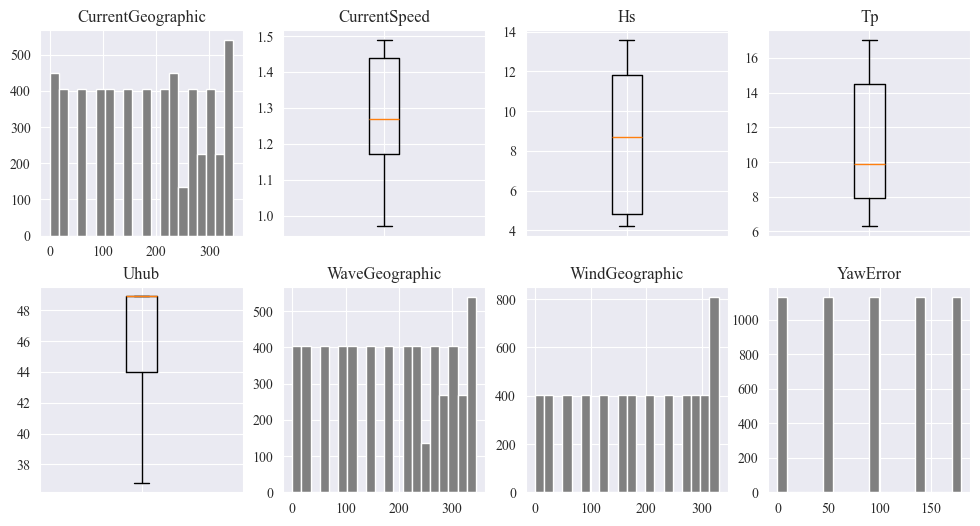

In [91]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
plt.rcParams["font.family"] = "Times New Roman"

# List of columns that need histograms instead of boxplots
degree_columns = ['CurrentGeographic', 'WaveGeographic', 'WindGeographic', 'YawError']

# Iterate over the columns in filtered_caselist
for i, column in enumerate(filtered_caselist.columns):
    # Calculate the subplot position
    row = i // 4
    col = i % 4
    
    # Check if the column is one of the degree_columns
    if column in degree_columns:
        # Create a histogram for the column
        axes[row, col].hist(filtered_caselist[column], bins=20, color='gray', alpha=1)
    else:
        # Create a boxplot for the current column
        axes[row, col].boxplot(filtered_caselist[column])
        axes[row, col].set_xticklabels([])
    
    # Set the title
    axes[row, col].set_title(f'{column}')
    

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.25)

# Show the plot
plt.show()


### Check for outliers

In [55]:
# Assuming 'df' is your DataFrame with the data
outliers = pd.DataFrame(columns=filtered_caselist.columns, index=['Lower Bound', 'Upper Bound', 'Outliers'])

for column in filtered_caselist.columns:
    # Calculate Q1 (25th percentile of the data) for the given column
    Q1 = filtered_caselist[column].quantile(0.25)
    # Calculate Q3 (75th percentile of the data) for the given column
    Q3 = filtered_caselist[column].quantile(0.75)
    # Calculate the IQR by subtracting Q1 from Q3
    IQR = Q3 - Q1
    
    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Find outliers
    outlier_condition = ((filtered_caselist[column] < lower_bound) | (filtered_caselist[column] > upper_bound))
    outliers.at['Lower Bound', column] = lower_bound
    outliers.at['Upper Bound', column] = upper_bound
    outliers.at['Outliers', column] = filtered_caselist[column][outlier_condition].tolist()

# Display outliers for each feature
outliers

CurrentGeographic CurrentSpeed    Hs    Tp   Uhub WaveGeographic  \
Lower Bound            -180.0        0.765  -5.7  -2.0  36.65         -202.5   
Upper Bound             540.0        1.845  22.3  24.4  56.25          577.5   
Outliers                   []           []    []    []     []             []   

            WindGeographic YawError  
Lower Bound         -202.5    -90.0  
Upper Bound          577.5    270.0  
Outliers                []       []

In [56]:
# Assuming 'outliers' is the DataFrame that contains your outlier data
# Iterate over each column and print the length of the outlier array
for column in outliers.columns:
    outlier_array = outliers.at['Outliers', column]
    # The outlier_array could be a list or a numpy array depending on how it's stored
    if isinstance(outlier_array, list):
        print(f'Number of outliers for {column}: {len(outlier_array)}')
    else:
        # Assuming the outlier_array is a numpy array
        print(f'Number of outliers for {column}: {outlier_array.size}')

Number of outliers for CurrentGeographic: 0
Number of outliers for CurrentSpeed: 0
Number of outliers for Hs: 0
Number of outliers for Tp: 0
Number of outliers for Uhub: 0
Number of outliers for WaveGeographic: 0
Number of outliers for WindGeographic: 0
Number of outliers for YawError: 0


### Correlation Analysis

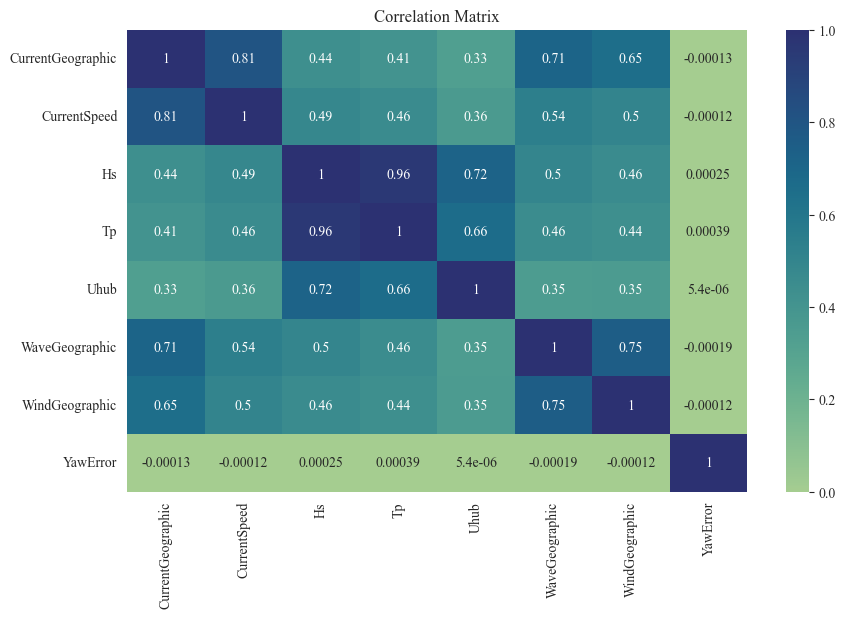

In [57]:
# Plot heatmap
plt.figure(figsize=(10, 6))
plt.rcParams["font.family"] = "Times New Roman"
sns.heatmap(filtered_caselist.corr(), annot=True, cmap='crest')
plt.title('Correlation Matrix')
plt.show()


### PCA Analysis

In [58]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming `filtered_caselist` is your DataFrame and it's already loaded in your environment.

# Step 1: Standardize the features since PCA is affected by scale
# (Note: Ensure that `filtered_caselist` contains only numeric data)
X = StandardScaler().fit_transform(filtered_caselist)

# Step 2: Create a PCA instance for 3 components
pca = PCA(n_components=3)

# Step 3: Fit and transform the standardized data using PCA
principal_components = pca.fit_transform(X)

# Step 4: Summarize the explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Printing the variance explained by the first 3 components
print(f"Explained variance by component: {explained_variance}")
print(f"Cumulative variance explained by the first 3 components: {cumulative_variance[2]}")

Explained variance by component: [0.53205289 0.164334   0.12499993]
Cumulative variance explained by the first 3 components: 0.8213868212568798


## Output Features (Sensors)

In [59]:
sim_results.drop(columns=['GroupID'], inplace=True)

### Descriptive Statistics

In [60]:
sim_results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5668 entries, 1 to 5669
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   49      5668 non-null   float64
 1   52      5668 non-null   float64
 2   59      5668 non-null   float64
 3   60      5668 non-null   float64
 4   164     5668 non-null   float64
 5   1477    5668 non-null   float64
 6   1493    5668 non-null   float64
 7   1509    5668 non-null   float64
 8   1525    5668 non-null   float64
 9   1541    5668 non-null   float64
 10  1563    5668 non-null   float64
 11  2348    5668 non-null   float64
dtypes: float64(12)
memory usage: 575.7 KB


In [61]:
sim_results.describe().round(2)

49       52       59       60         164      1477      1493  \
count  5668.00  5668.00  5668.00  5668.00     5668.00   5668.00   5668.00   
mean      2.36     4.41    24.23     4.81   559299.51   2804.83   2784.88   
std       1.55     3.83     7.18     1.81   163086.79   2294.57   2327.85   
min      -0.31    -4.84    10.93     1.06   185608.85    477.28    479.73   
25%       1.02     1.26    17.39     3.44   438478.90    833.10    847.47   
50%       1.79     4.64    24.76     4.64   551241.23   1898.04   1836.58   
75%       3.74     7.15    30.16     6.09   673828.15   4421.16   4602.33   
max       6.36    15.94    45.16    10.36  1170724.99  11775.48  11858.36   

           1509      1525      1541      1563     2348  
count   5668.00   5668.00   5668.00   5668.00  5668.00  
mean    4433.78   4733.04   2828.52   9265.77     2.52  
std     2447.24   2989.37   2328.45   4964.04     0.77  
min     1096.19   1026.78    489.03   2939.37     1.11  
25%     2172.75   2020.56    843.86   5317.02     1.88  
50%     4145.80   4060.66   1881.10   7799.07     2.47  
75%     6441.59   6984.21   4654.77  11882.68     3.06  
max    17259.44  15001.73  11805.12  31865.58     5.35

In [62]:
import numpy as np

# Calculate the IQR for each column
iqr_values = sim_results.apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# Print the IQR values
print(round(iqr_values, 2))

49           2.72
52           5.89
59          12.77
60           2.65
164     235349.25
1477      3588.06
1493      3754.86
1509      4268.84
1525      4963.65
1541      3810.91
1563      6565.67
2348         1.17
dtype: float64


### Boxplots for all outputs

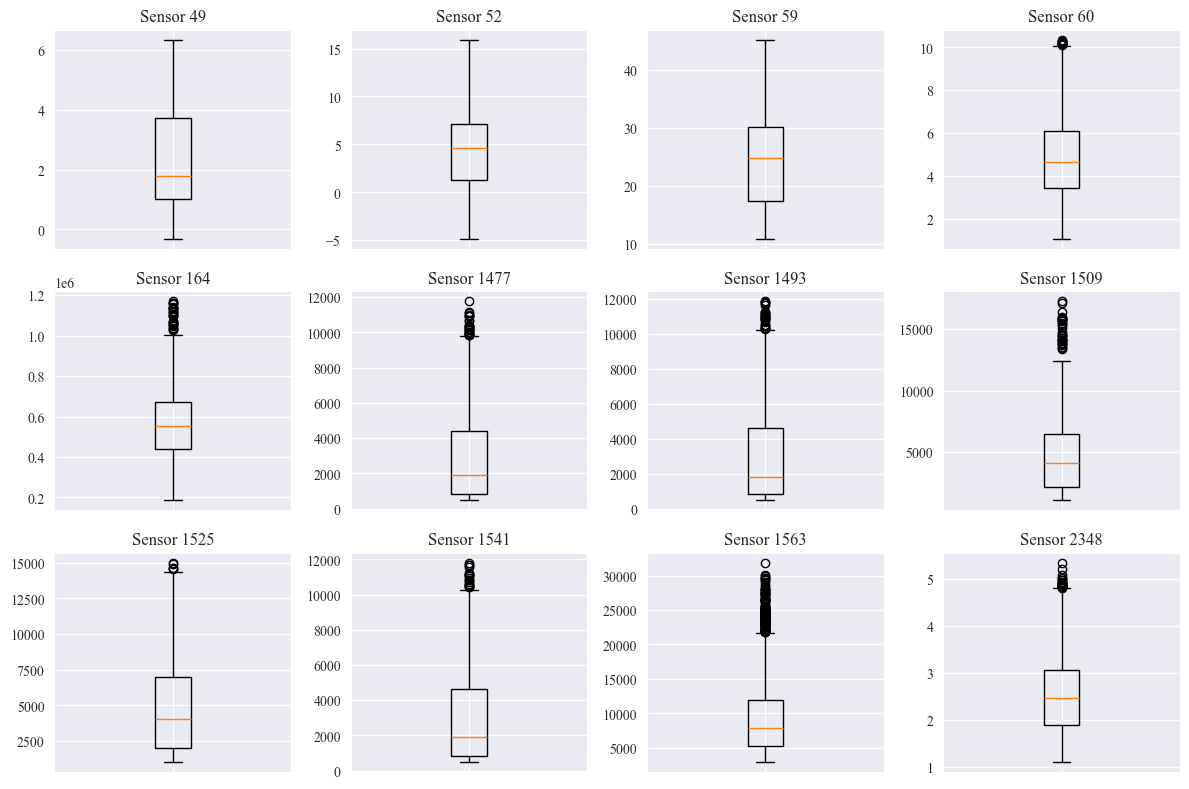

In [63]:
import matplotlib.pyplot as plt

# Setting the style globally, for all plots
plt.rcParams["font.family"] = "Times New Roman"

# Assume sim_results is already defined and is the DataFrame you're working with
# You have 12 columns to plot, so you need 4 rows and 3 columns in your subplot grid
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over the columns in sim_results and the flattened axes simultaneously
for ax, column in zip(axes, sim_results.columns):
    # Create a boxplot for the current column on the current axes
    ax.boxplot(sim_results[column])
    
    # Set the title for the current axes
    ax.set_title(f'Sensor {column}')
    # Remove the x-axis labels (uncomment if needed)
    ax.set_xticklabels([])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


### Check for outliers

In [64]:
# Assuming 'df' is your DataFrame with the data
outliers = pd.DataFrame(columns=sim_results.columns, index=['Lower Bound', 'Upper Bound', 'Outliers'])

for column in sim_results.columns:
    # Calculate Q1 (25th percentile of the data) for the given column
    Q1 = sim_results[column].quantile(0.25)
    # Calculate Q3 (75th percentile of the data) for the given column
    Q3 = sim_results[column].quantile(0.75)
    # Calculate the IQR by subtracting Q1 from Q3
    IQR = Q3 - Q1
    
    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Find outliers
    outlier_condition = ((sim_results[column] < lower_bound) | (sim_results[column] > upper_bound))
    outliers.at['Lower Bound', column] = lower_bound
    outliers.at['Upper Bound', column] = upper_bound
    outliers.at['Outliers', column] = sim_results[column][outlier_condition].tolist()

# Display outliers for each feature
outliers

49         52         59  \
Lower Bound -3.053167  -7.565909   -1.76542   
Upper Bound  7.816002  15.978367  49.310435   
Outliers           []         []         []   

                                                            60  \
Lower Bound                                          -0.538712   
Upper Bound                                          10.065657   
Outliers     [10.229078700507555, 10.360393548609057, 10.14...   

                                                           164  \
Lower Bound                                        85455.03025   
Upper Bound                                     1026852.029245   
Outliers     [1063238.4589068566, 1170724.9904252382, 11361...   

                                                          1477  \
Lower Bound                                       -4548.993584   
Upper Bound                                        9803.258064   
Outliers     [10192.6494140625, 10391.2890625, 9989.4248046...   

                                                          1493  \
Lower Bound                                       -4784.821701   
Upper Bound                                       10234.625443   
Outliers     [11730.6455078125, 10483.44921875, 10668.49023...   

                                                          1509  \
Lower Bound                                       -4230.514221   
Upper Bound                                       12844.849548   
Outliers     [14442.1865234375, 13350.9296875, 13855.148437...   

                                                          1525  \
Lower Bound                                       -5424.911575   
Upper Bound                                       14429.685226   
Outliers     [14571.212890625, 14900.9765625, 15001.7275390...   

                                                          1541  \
Lower Bound                                       -4872.504913   
Upper Bound                                       10371.131073   
Outliers     [11544.212890625, 11658.6611328125, 10461.0351...   

                                                          1563  \
Lower Bound                                       -4531.481804   
Upper Bound                                       21731.181428   
Outliers     [21819.11709661156, 24607.48245479766, 27796.7...   

                                                          2348  
Lower Bound                                           0.124441  
Upper Bound                                           4.816811  
Outliers     [4.983089496199279, 5.013765389289928, 4.81772...

In [65]:
# Assuming 'outliers' is the DataFrame that contains your outlier data
# Iterate over each column and print the length of the outlier array
for column in outliers.columns:
    outlier_array = outliers.at['Outliers', column]
    # The outlier_array could be a list or a numpy array depending on how it's stored
    if isinstance(outlier_array, list):
        print(f'Number of outliers for {column}: {len(outlier_array)}')
    else:
        # Assuming the outlier_array is a numpy array
        print(f'Number of outliers for {column}: {outlier_array.size}')


Number of outliers for 49: 0
Number of outliers for 52: 0
Number of outliers for 59: 0
Number of outliers for 60: 11
Number of outliers for 164: 27
Number of outliers for 1477: 26
Number of outliers for 1493: 26
Number of outliers for 1509: 32
Number of outliers for 1525: 5
Number of outliers for 1541: 19
Number of outliers for 1563: 132
Number of outliers for 2348: 29


### Correlation Analysis

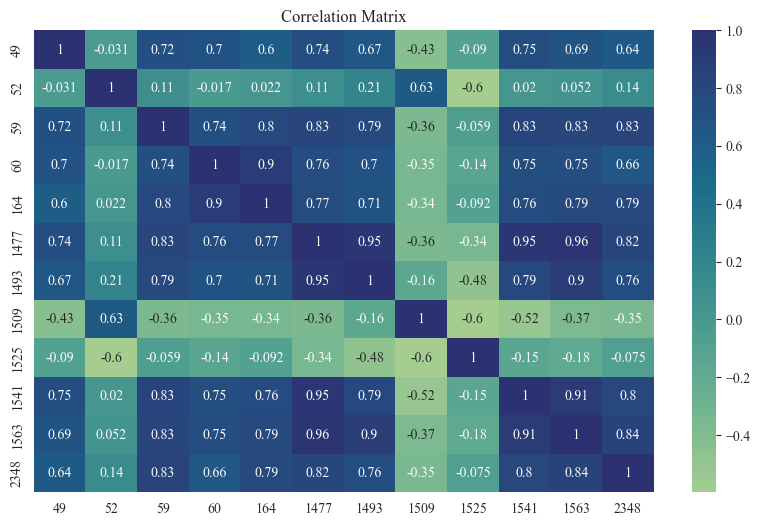

In [66]:
# Plot heatmap
plt.figure(figsize=(10, 6))
plt.rcParams["font.family"] = "Times New Roman"
sns.heatmap(sim_results.corr(), annot=True, cmap='crest')
plt.title('Correlation Matrix')
plt.show()


### PC1 vs Sensor Plots
- use the sin cos geogrpaical data
- use only 1890 instead of 5760

In [67]:
sim_results

49        52         59        60            164  \
simulation_id                                                           
1              1.691887 -2.120961  18.965508  4.103344  572147.297447   
2              1.250475 -1.011889  17.376253  3.133629  437043.607936   
3              1.363898 -0.269001  18.012307  3.873457  553222.715490   
4              1.021289 -0.522990  17.559575  2.982816  522729.357912   
5              2.149652  5.092750  22.914839  3.082897  411877.701497   
...                 ...       ...        ...       ...            ...   
5665           0.683119  0.764273  19.953560  3.989195  530876.222038   
5666           5.127405  8.587289  29.656173  6.097249  567520.837672   
5667           1.423191  2.257077  23.684501  3.510680  441296.787171   
5668           1.226076  2.450841  25.256802  3.337757  477359.503286   
5669           4.739855  8.695686  32.855767  5.624708  635540.553289   

                      1477         1493         1509          1525  \
simulation_id                                                        
1               642.009155   628.924316  3369.619629   8743.897461   
2               723.585144   698.690552  3120.203369   8305.519531   
3               634.899475   627.509644  3228.936035   8404.508789   
4               749.992554   728.521240  3025.437744   8423.188477   
5              1386.479248  1302.627930  2150.176758   9823.062500   
...                    ...          ...          ...           ...   
5665            645.002991   635.562012  4980.209473   9143.626953   
5666           3867.829346  4879.607422  5006.321289   1941.879517   
5667           1854.119995  1613.260010  1754.702881   8440.926758   
5668           1640.242065  1395.244995  1781.616089  10422.503906   
5669           3779.549072  4851.986328  5987.371094   1655.894653   

                      1541          1563      2348  
simulation_id                                       
1               693.981445   6854.937477  1.889086  
2               792.834595   6434.088664  1.905250  
3               687.081482   6432.264117  2.129340  
4               810.803101   6550.237208  2.583491  
5              1885.004883   8190.089347  2.711316  
...                    ...           ...       ...  
5665            726.015259   7329.141337  2.064749  
5666           2957.632568  10010.185484  2.623968  
5667           2246.303223   6971.787400  2.656162  
5668           1913.273438   8801.555657  3.486386  
5669           2754.971680  10059.314658  2.771586  

[5668 rows x 12 columns]

In [68]:
caselist

CurrentGeographic CurrentSpeed    Hs     Tp  Uhub  \
simulation_id                                                     
1                            90         1.21   6.1    9.9  46.3   
2                            90         1.21   6.1    9.9  46.3   
3                            90         1.21   6.1      9  46.3   
4                            90         1.21   6.1    8.1  46.3   
5                            30         1.17   8.7   10.5  46.3   
...                         ...          ...   ...    ...   ...   
5665                         90         1.21   4.8   7.29  36.8   
5666                        300         1.44  11.8   14.5  44.9   
5667                          0         0.97   8.7  11.55  48.9   
5668                         60         1.27   8.7   9.45  48.9   
5669                        300         1.44  11.8   14.5  44.9   

              WaveGeographic WindGeographic YawError  GroupID  
simulation_id                                                  
1                         60             60      135      312  
2                         60             60      180      315  
3                         60             60      135      311  
4                         60             60      180      313  
5                         30             60        0      317  
...                      ...            ...      ...      ...  
5665                      90             90       45      409  
5666                     270            240       45     1205  
5667                      30              0      180      120  
5668                      30              0        0      121  
5669                     270            240       45     1205  

[5669 rows x 9 columns]

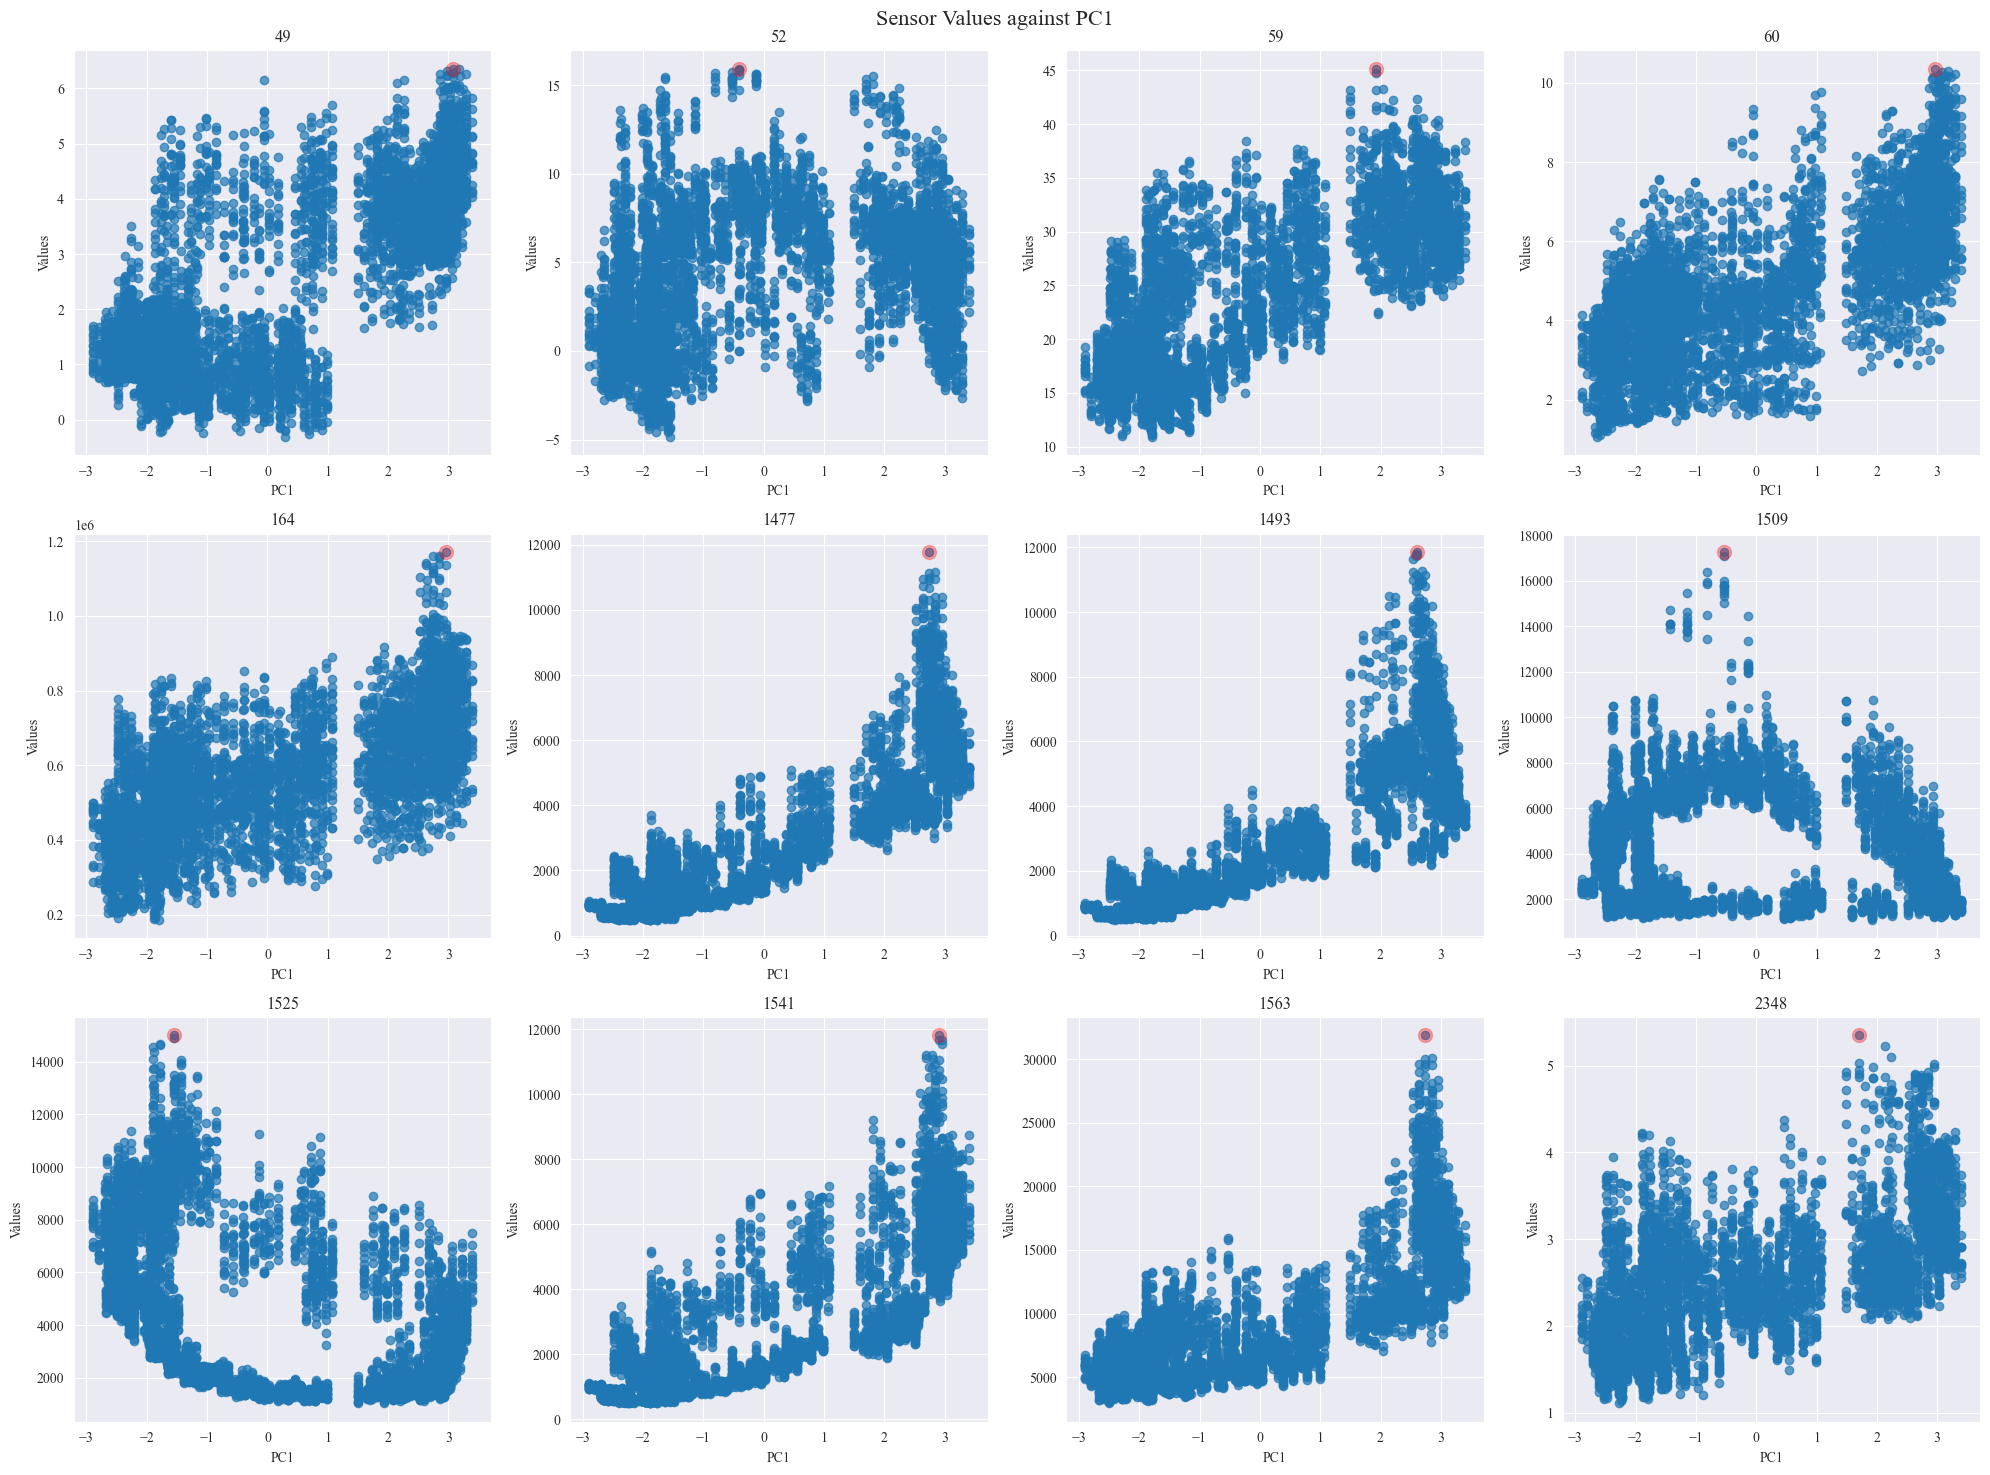

In [69]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assume 'filtered_caselist' is your DataFrame and 'sim_results' contains sensor data.

# Step 1: Standardize the features since PCA is affected by scale
X_standardized = StandardScaler().fit_transform(filtered_caselist)

# Step 2: Perform PCA to extract the principal components
pca = PCA(n_components=1)  # We only need the first PC for this plot
principal_components = pca.fit_transform(X_standardized)

# Step 3: Extract PC1
#pc1 = principal_components[:, 0]

filtered_caselist['PC1'] = principal_components[:, 0]

# Plotting code (assuming alignment is corrected as per the chosen option above)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
fig.suptitle('Sensor Values against PC1', fontsize=16)
axes = axes.flatten()

for i, sensor in enumerate(sim_results.columns):  # Ensure alignment with the PCA results
    pc1_values = filtered_caselist['PC1']  # This assumes the 'PC1' column is added to the DataFrame
    sensor_values = sim_results[sensor]
    axes[i].scatter(pc1_values, sensor_values, alpha=0.7)

    # Highlighting the max point
    max_value = sensor_values.max()
    max_index = sensor_values.idxmax()
    max_pc1_value = pc1_values[max_index]  # Now it should align correctly
    axes[i].scatter(max_pc1_value, max_value, color='red', label='Highest Value', zorder=5, s=100, alpha=0.3)
    #axes[i].axhline(y=max_value, color='red', linestyle='-', label='Max Value', zorder=5)
    
    axes[i].set_title(f'{sensor}')
    axes[i].set_xlabel('PC1')
    axes[i].set_ylabel('Values')
    #axes[i].legend()

plt.tight_layout() #rect=[0, 0.03, 1, 0.95]
plt.show()

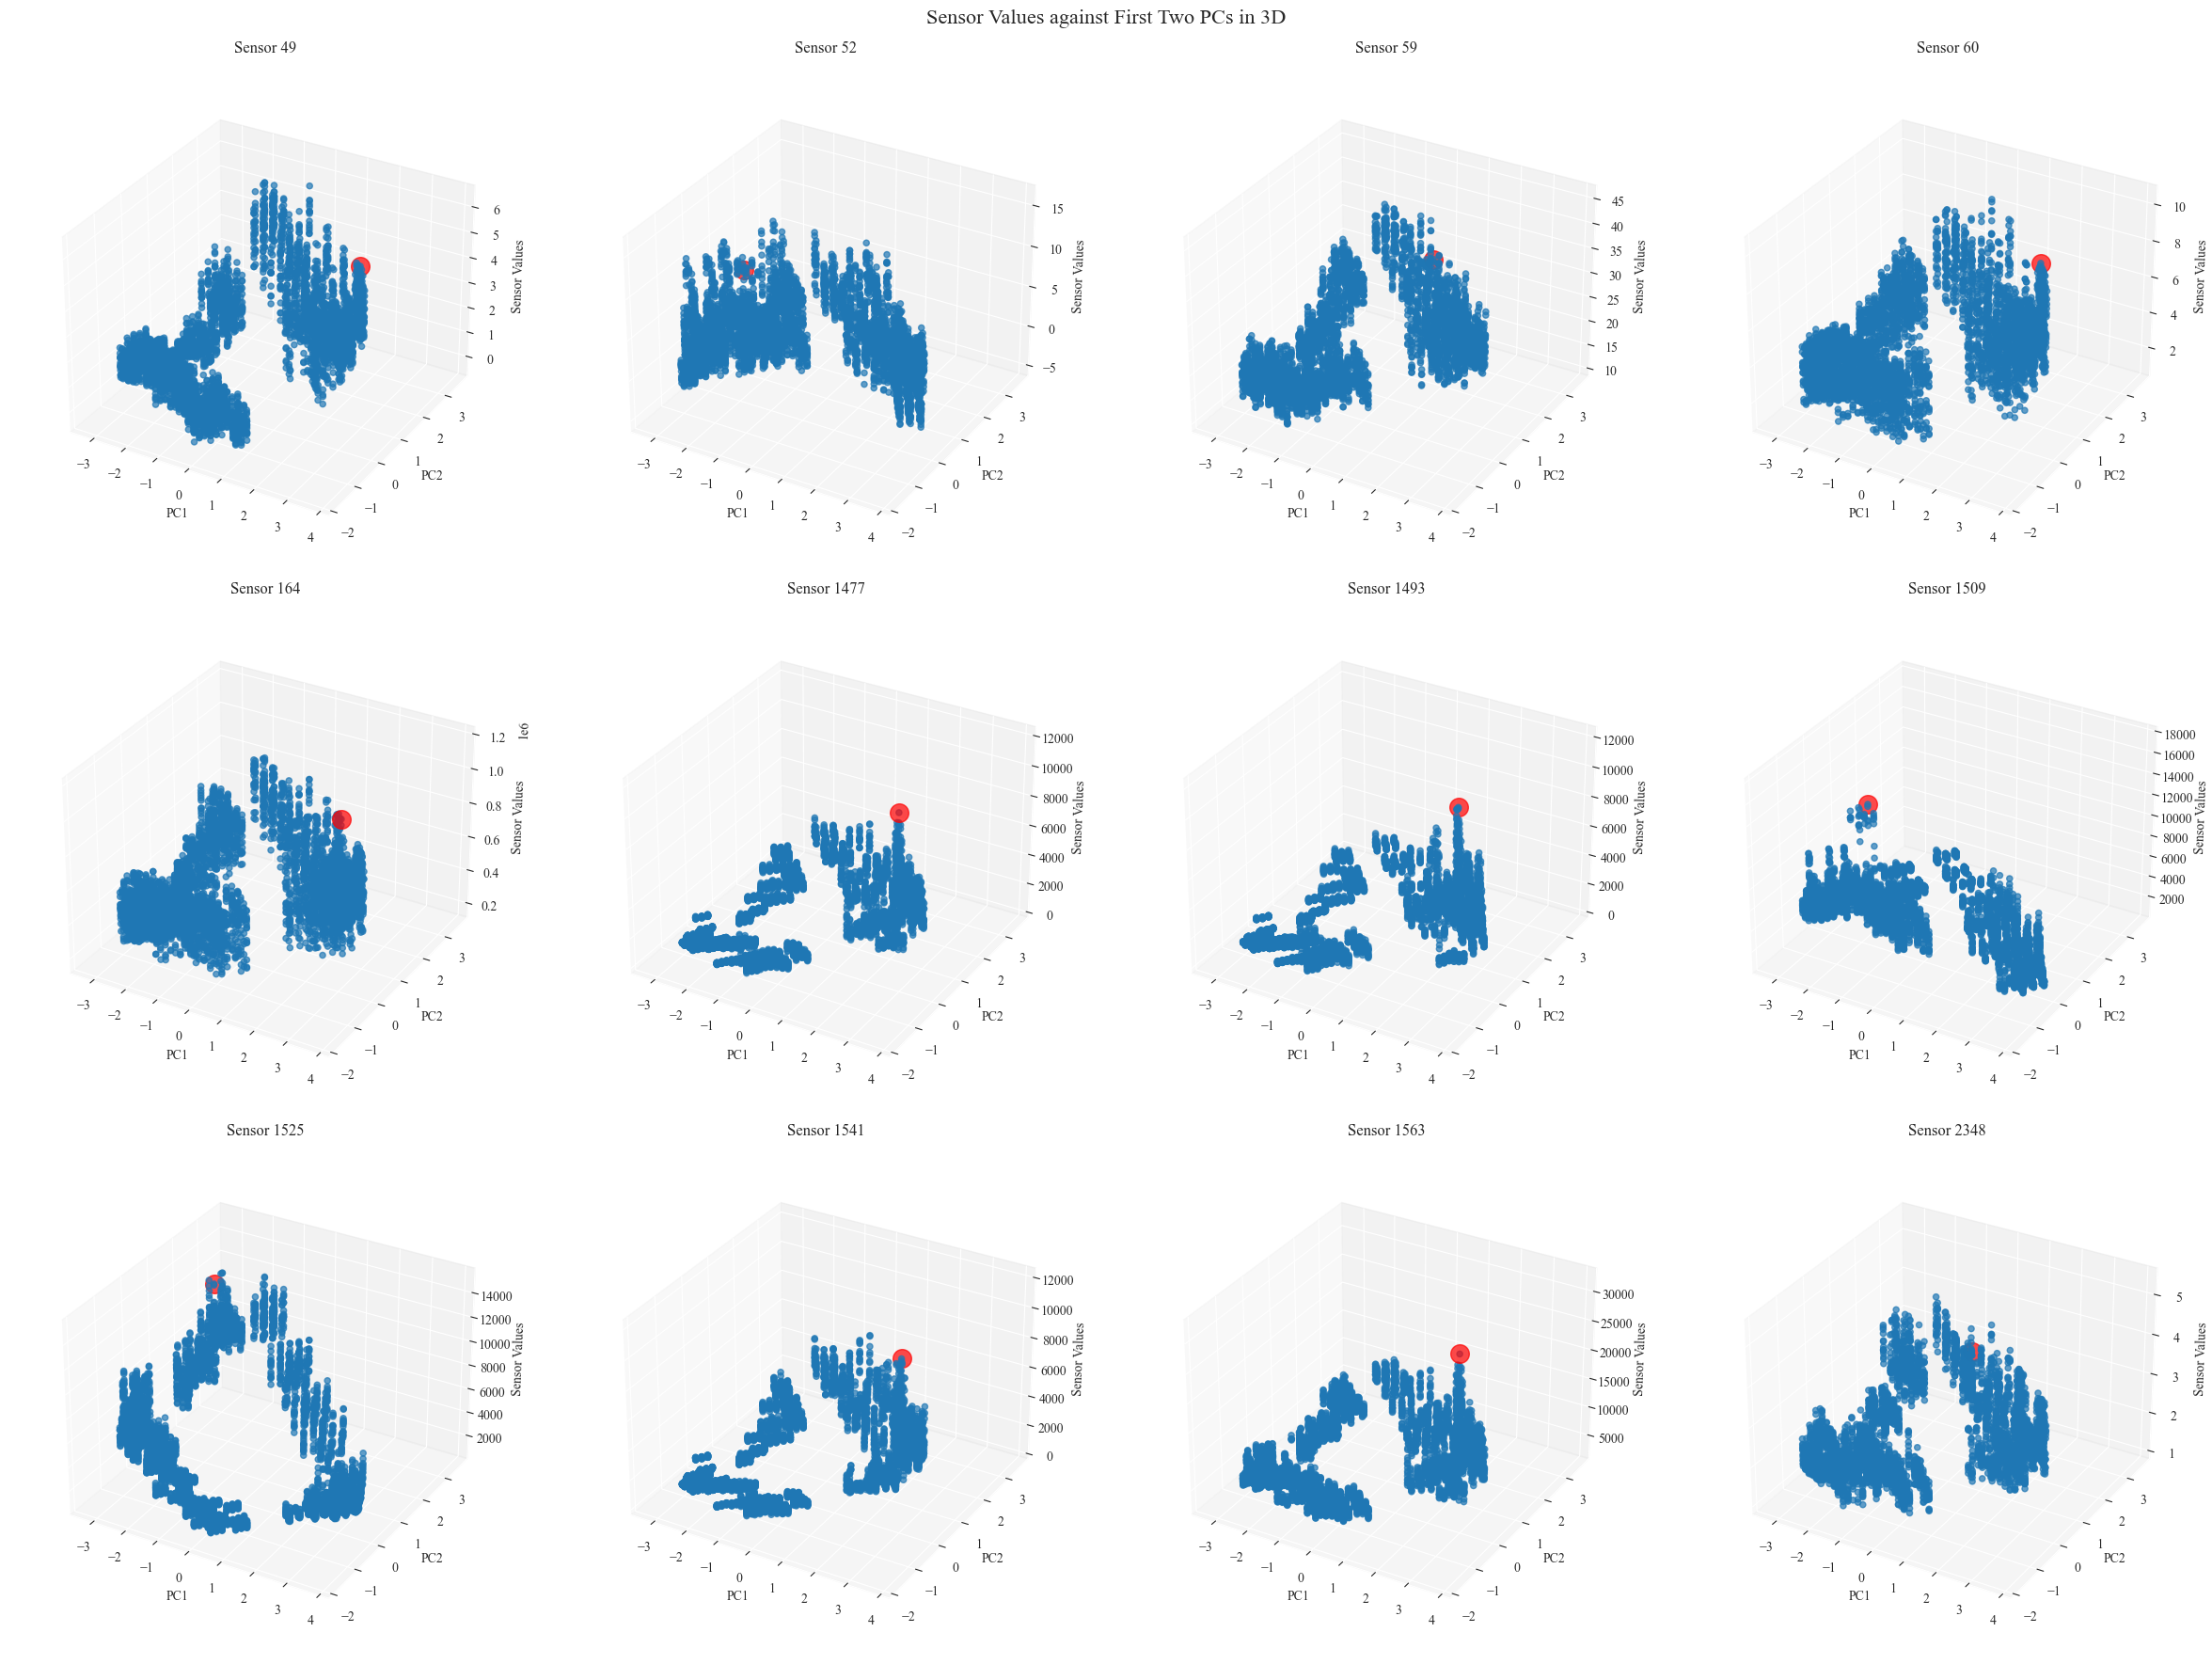

In [70]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assume 'filtered_caselist' is your DataFrame and contains only the input features.

# Step 1: Standardize the features since PCA is affected by scale
X_standardized = StandardScaler().fit_transform(filtered_caselist)

# Step 2: Perform PCA to extract the first two principal components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_standardized)

# Step 3: Add the first two PCs to the 'filtered_caselist' DataFrame
filtered_caselist['PC1'] = principal_components[:, 0]
filtered_caselist['PC2'] = principal_components[:, 1]

# Step 4: Prepare the figure for a 3x4 grid of 3D subplots, adjust the figure size if needed
fig = plt.figure(figsize=(24, 18))  # Increase the width of the figure to prevent cutting off
fig.suptitle('Sensor Values against First Two PCs in 3D', fontsize=16)

# Loop through each sensor and create the 3D plots
for i, sensor in enumerate(sim_results.columns, start=1):
    ax = fig.add_subplot(3, 4, i, projection='3d')

    # We use the first two PCs for the x and y axes, and sensor values for the z-axis
    ax.scatter(filtered_caselist['PC1'], filtered_caselist['PC2'], sim_results[sensor], alpha=0.7)

    # Identify and plot the highest value in the sensor column
    max_value = sim_results[sensor].max()
    max_value_index = sim_results[sensor].idxmax()
    ax.scatter(filtered_caselist.loc[max_value_index, 'PC1'], filtered_caselist.loc[max_value_index, 'PC2'], max_value, color='red', s=200, label='Highest Value', alpha=0.7)

    # Set labels and title for each subplot
    ax.set_title(f'Sensor {sensor}')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel(f'Sensor Values')
    ax.set_facecolor('#FFFFFF')
    ax.set_box_aspect(aspect=None, zoom=0.9)

# Adjust the layout so the subplots fit into the figure area, modify padding if necessary
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the top spacing for the suptitle

# Show the plot
plt.show()

In [97]:
sim_results.drop(columns=['GroupID'], inplace=True)

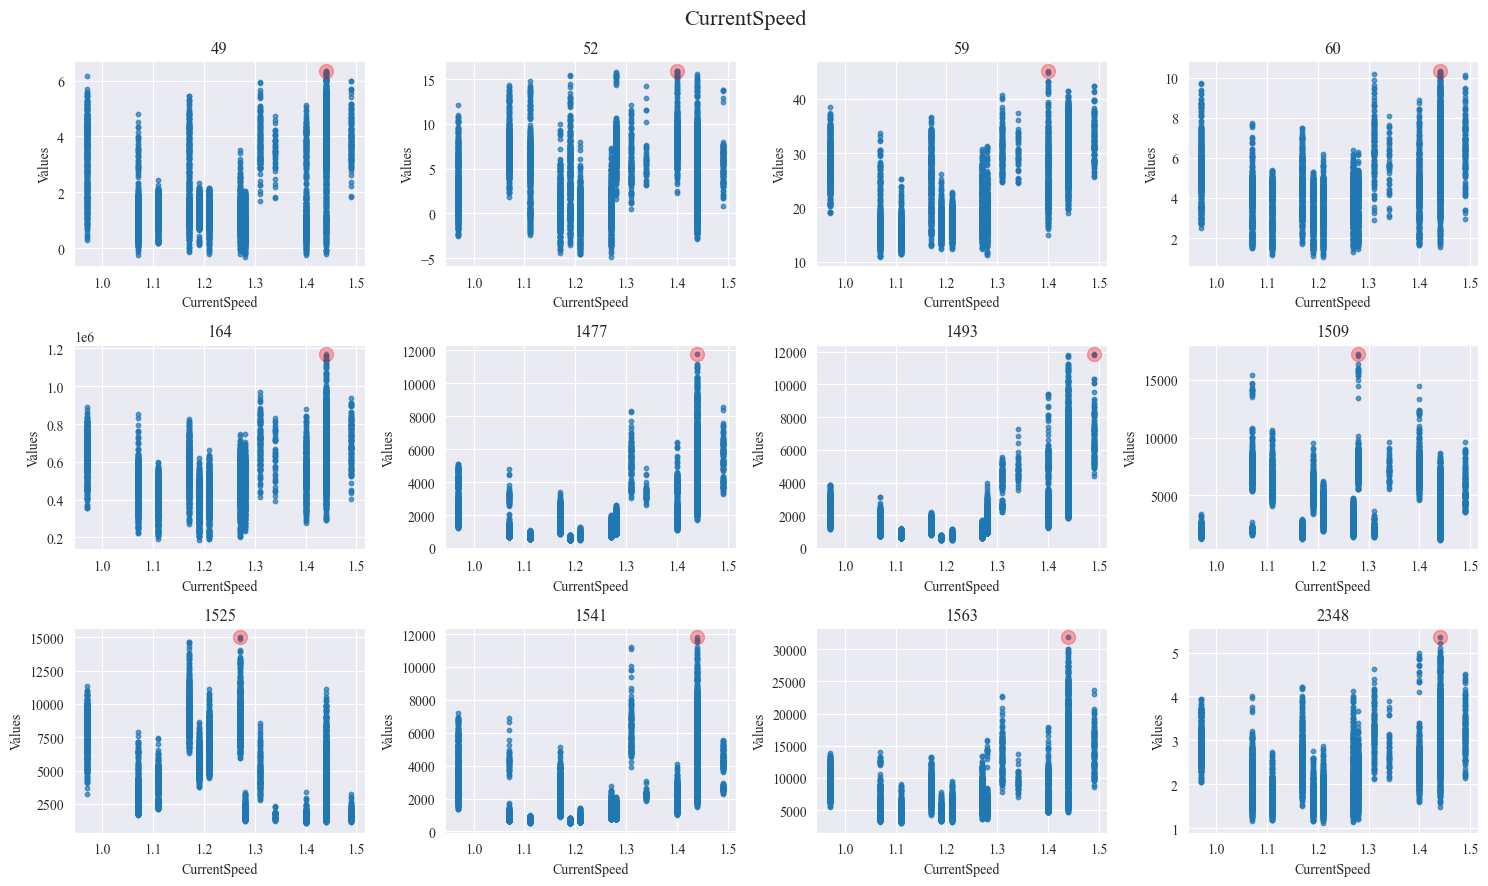

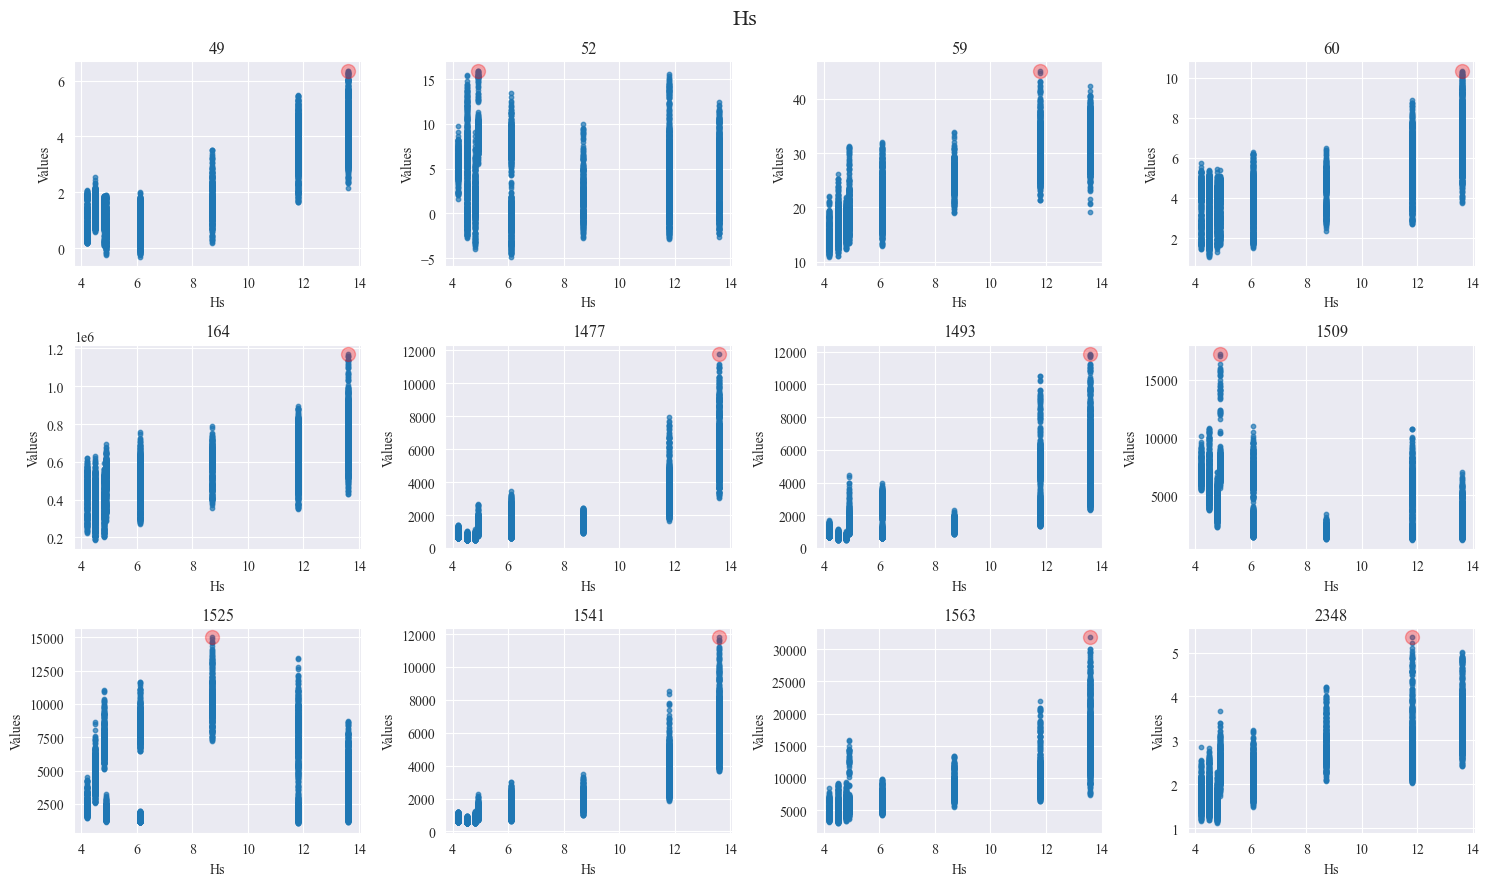

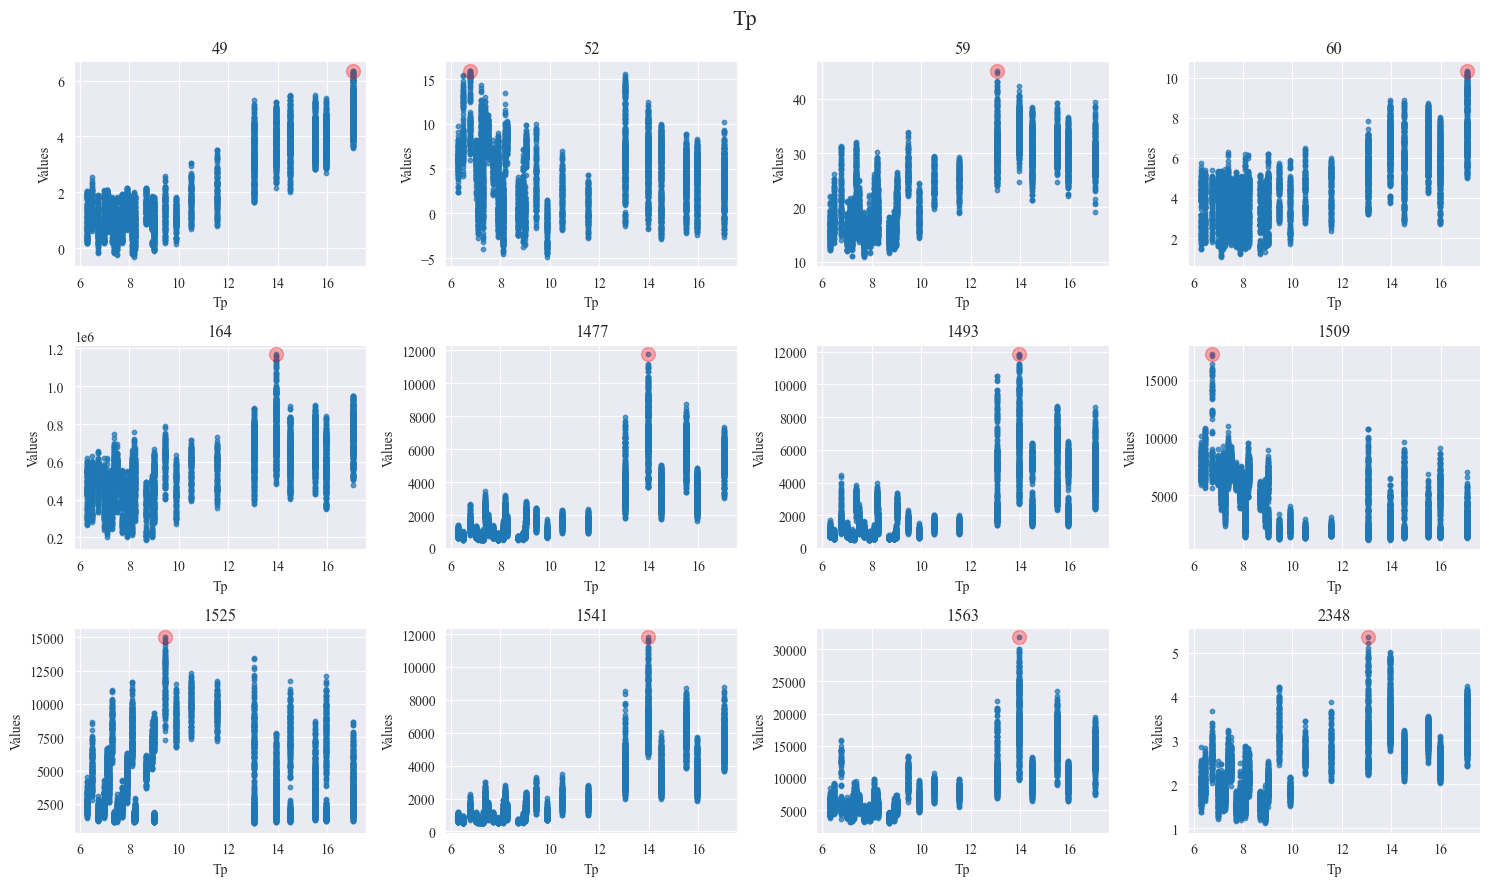

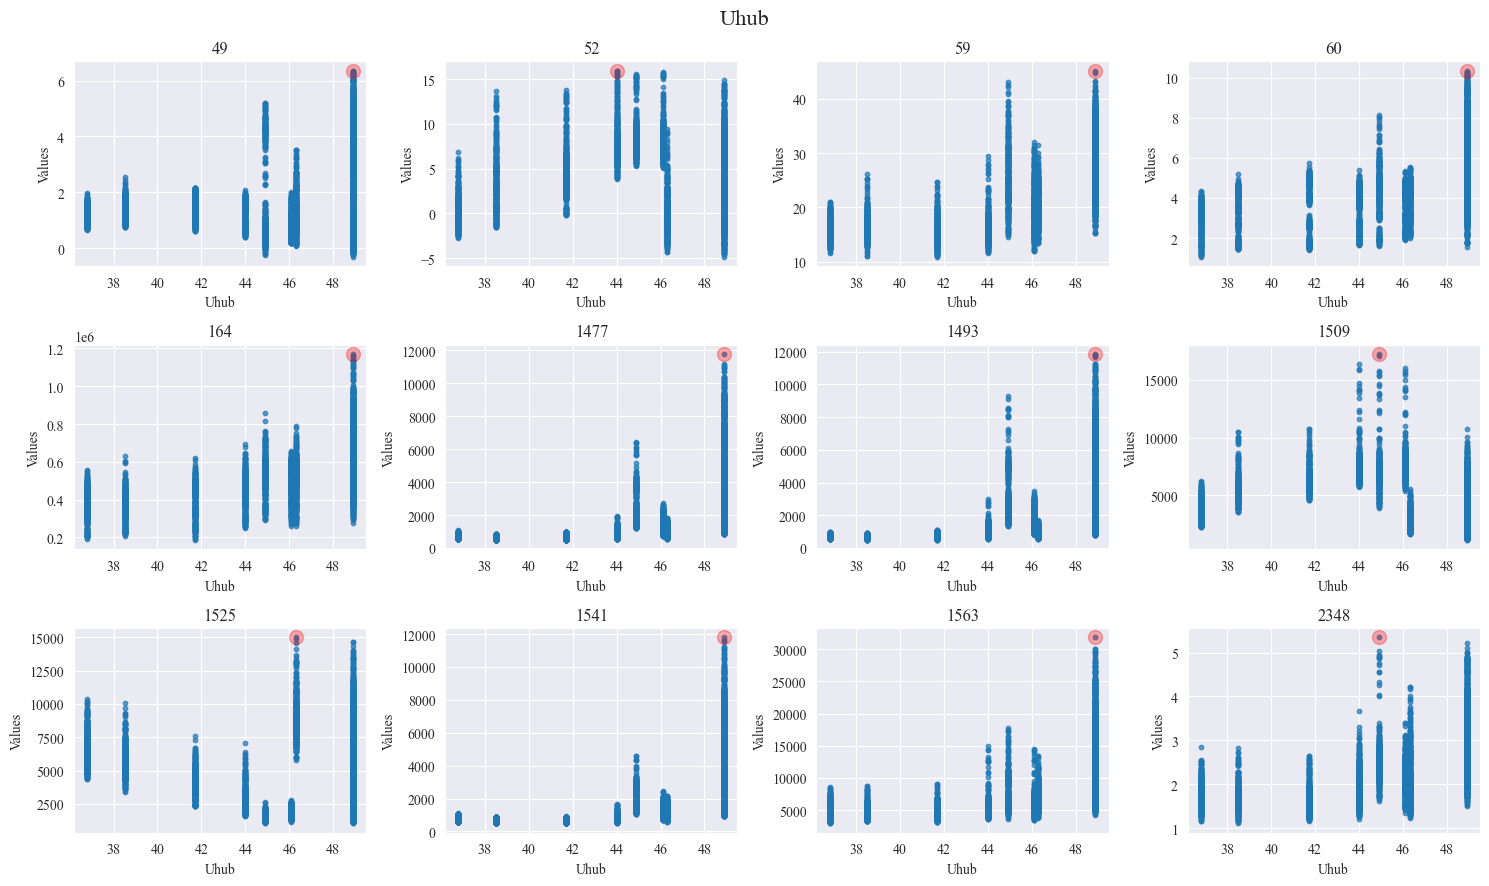

In [102]:
notplot_columns = ['CurrentGeographic', 'WaveGeographic', 'WindGeographic', 'YawError', 'PC1', 'PC2']

for current_col in filtered_caselist.columns:
    if current_col not in notplot_columns:

        fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 9))
        fig.suptitle(current_col, fontsize=16)
        axes = axes.flatten()

        for i, sensor in enumerate(sim_results.columns):  # Ensure alignment with the PCA results
            current_values = filtered_caselist[current_col]  # This assumes the 'PC1' column is added to the DataFrame
            sensor_values = sim_results[sensor]
            axes[i].scatter(current_values, sensor_values, alpha=0.7, s=10)

            # Highlighting the max point
            max_value = sensor_values.max()
            max_index = sensor_values.idxmax()
            max_x_value = current_values[max_index]  # Now it should align correctly
            axes[i].scatter(max_x_value, max_value, color='red', label='Highest Value', zorder=5, s=100, alpha=0.3)
            
            axes[i].set_title(f'{sensor}')
            axes[i].set_xlabel(current_col)
            axes[i].set_ylabel('Values')

        plt.tight_layout()
        plt.show()

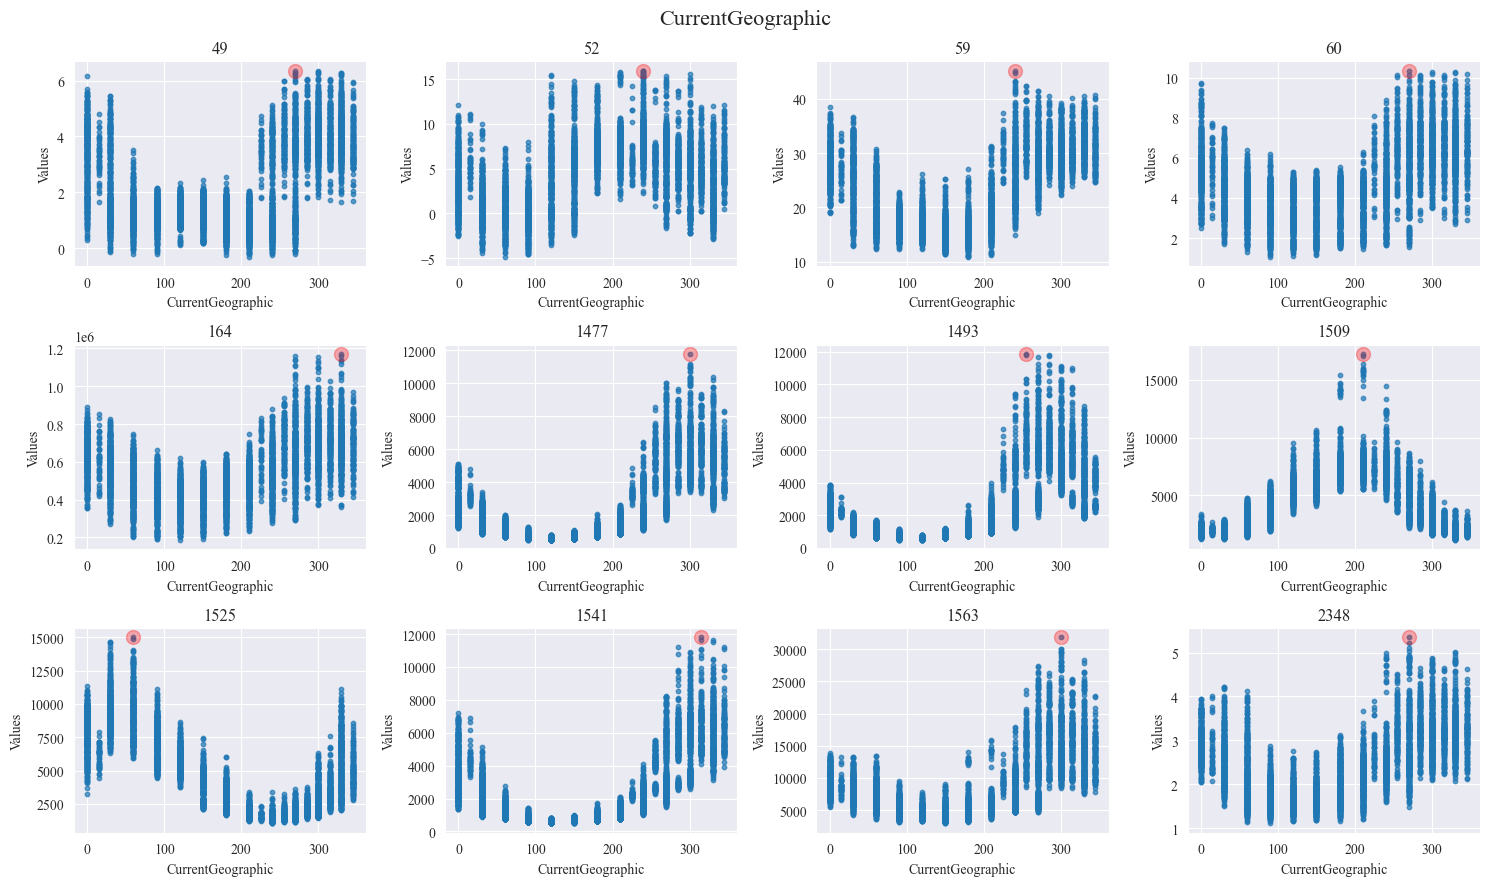

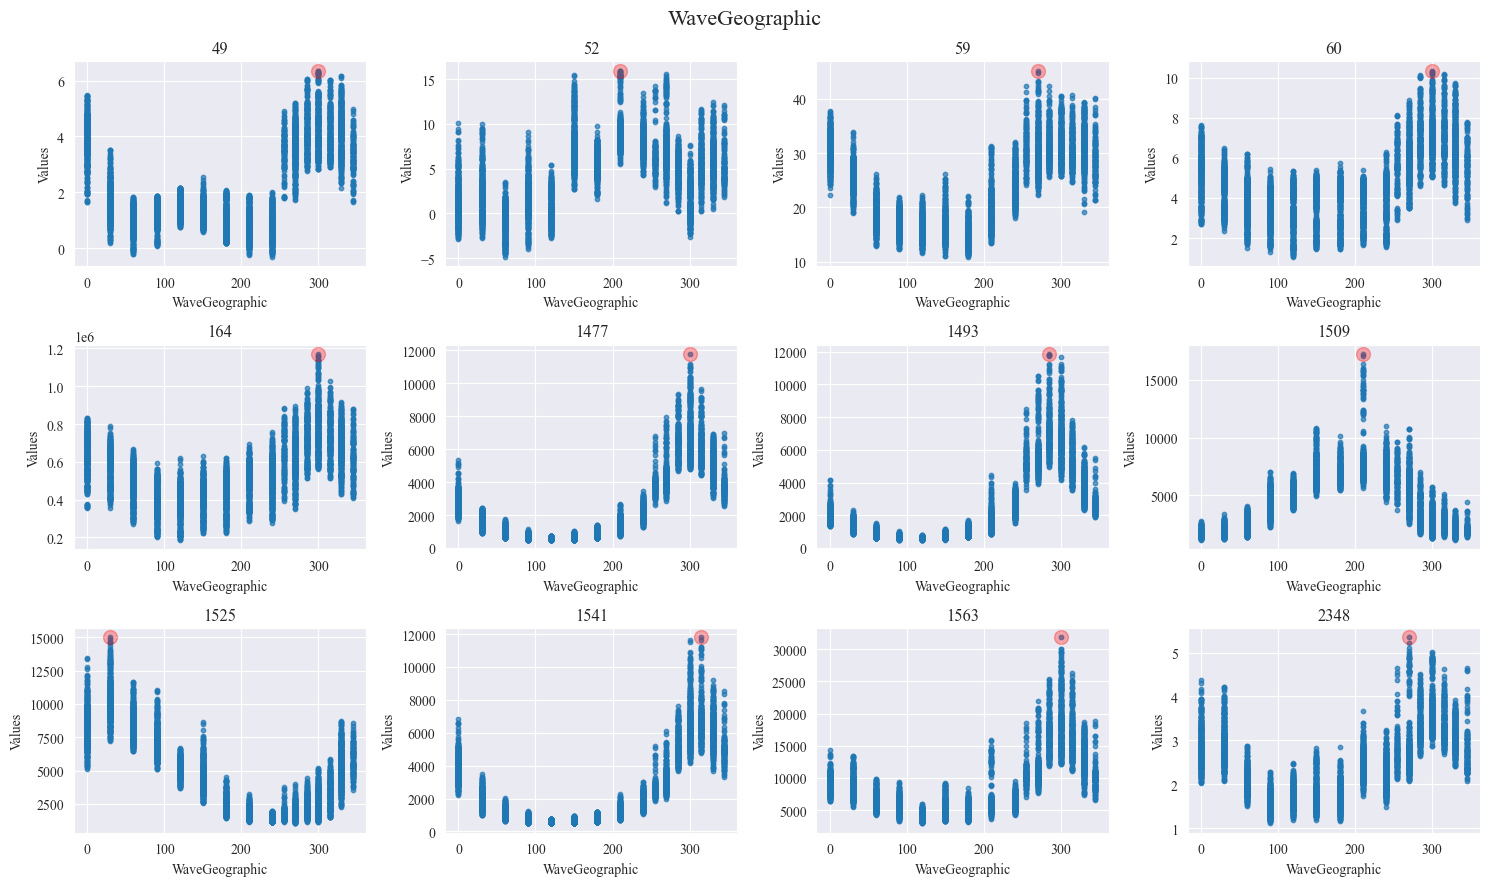

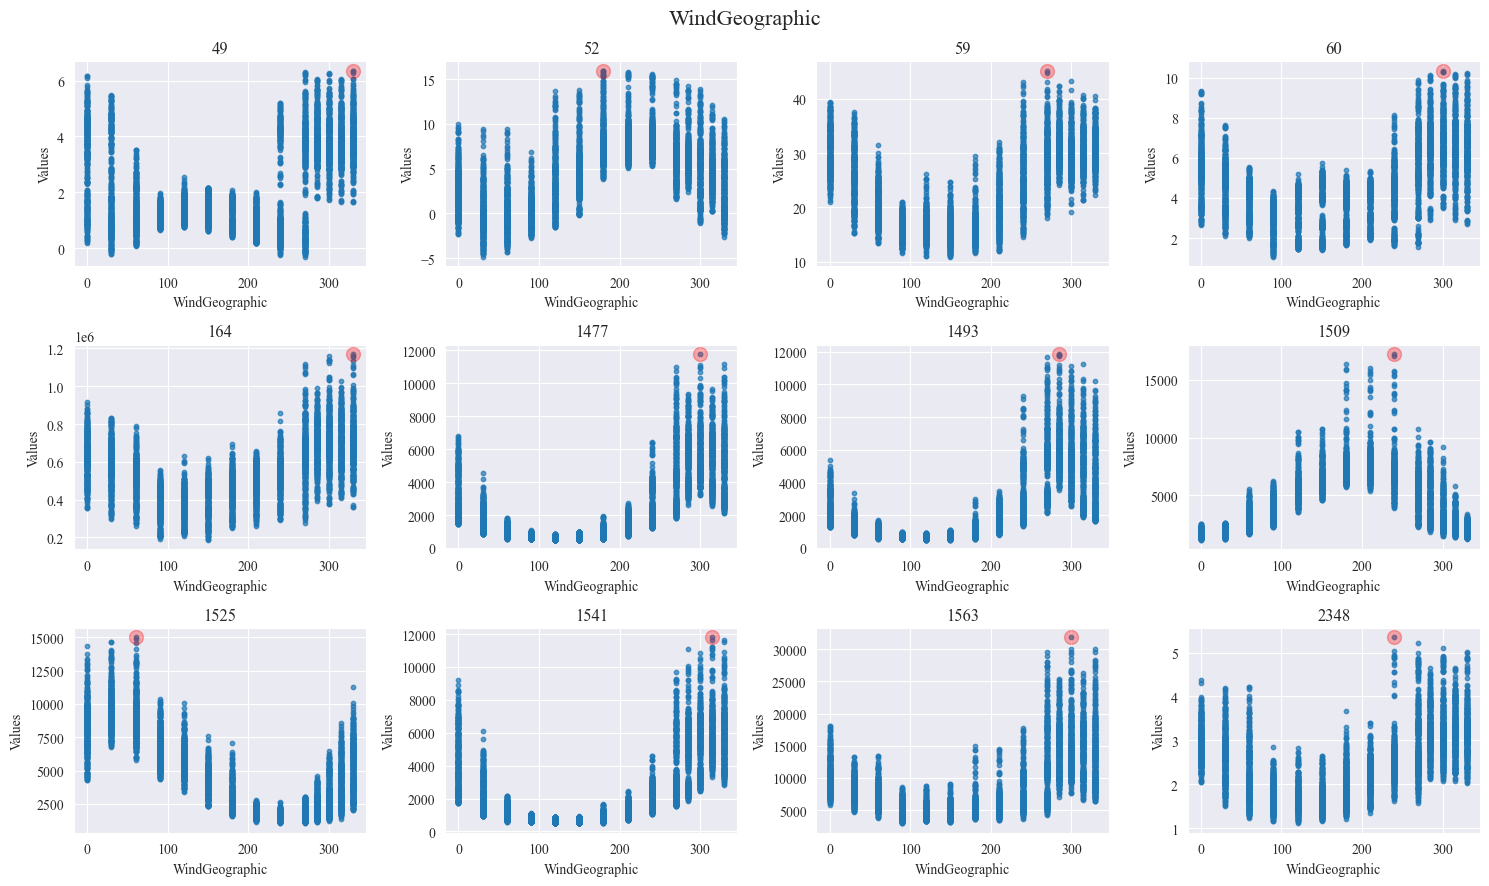

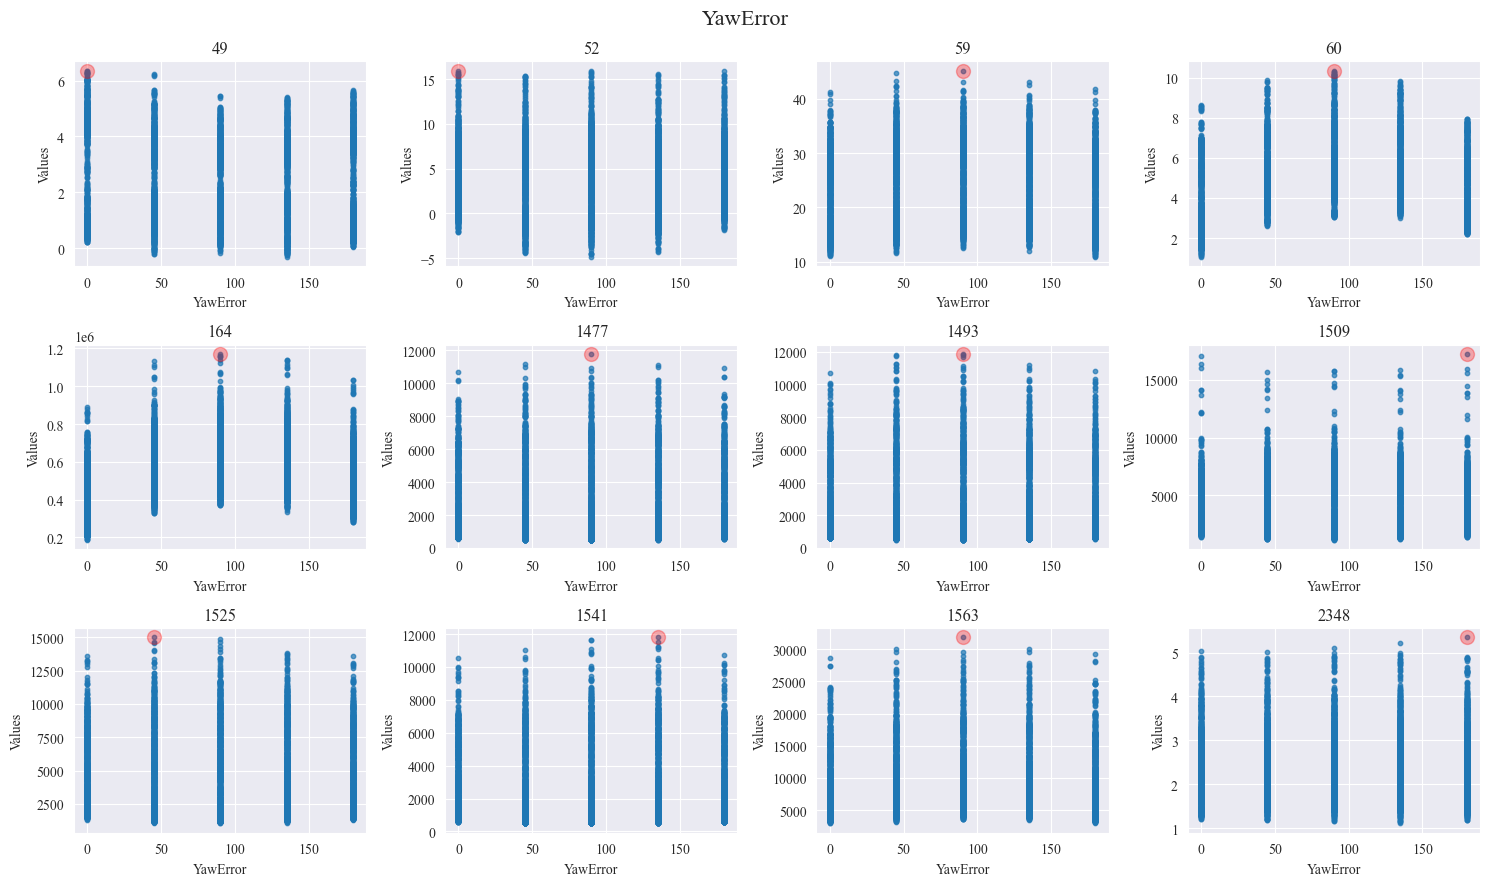

In [103]:
notplot_columns = ['CurrentGeographic', 'WaveGeographic', 'WindGeographic', 'YawError']

for current_col in filtered_caselist.columns:
    if current_col in notplot_columns:

        fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 9))
        fig.suptitle(current_col, fontsize=16)
        axes = axes.flatten()

        for i, sensor in enumerate(sim_results.columns):  # Ensure alignment with the PCA results
            current_values = filtered_caselist[current_col]  # This assumes the 'PC1' column is added to the DataFrame
            sensor_values = sim_results[sensor]
            axes[i].scatter(current_values, sensor_values, alpha=0.7, s=10)

            # Highlighting the max point
            max_value = sensor_values.max()
            max_index = sensor_values.idxmax()
            max_x_value = current_values[max_index]  # Now it should align correctly
            axes[i].scatter(max_x_value, max_value, color='red', label='Highest Value', zorder=5, s=100, alpha=0.3)
            
            axes[i].set_title(f'{sensor}')
            axes[i].set_xlabel(current_col)
            axes[i].set_ylabel('Values')

        plt.tight_layout()
        plt.show()

In [7]:
sim_results

49        52         59        60            164  \
simulation_id                                                           
1              1.691887 -2.120961  18.965508  4.103344  572147.297447   
2              1.250475 -1.011889  17.376253  3.133629  437043.607936   
3              1.363898 -0.269001  18.012307  3.873457  553222.715490   
4              1.021289 -0.522990  17.559575  2.982816  522729.357912   
5              2.149652  5.092750  22.914839  3.082897  411877.701497   
...                 ...       ...        ...       ...            ...   
5665           0.683119  0.764273  19.953560  3.989195  530876.222038   
5666           5.127405  8.587289  29.656173  6.097249  567520.837672   
5667           1.423191  2.257077  23.684501  3.510680  441296.787171   
5668           1.226076  2.450841  25.256802  3.337757  477359.503286   
5669           4.739855  8.695686  32.855767  5.624708  635540.553289   

                      1477         1493         1509          1525  \
simulation_id                                                        
1               642.009155   628.924316  3369.619629   8743.897461   
2               723.585144   698.690552  3120.203369   8305.519531   
3               634.899475   627.509644  3228.936035   8404.508789   
4               749.992554   728.521240  3025.437744   8423.188477   
5              1386.479248  1302.627930  2150.176758   9823.062500   
...                    ...          ...          ...           ...   
5665            645.002991   635.562012  4980.209473   9143.626953   
5666           3867.829346  4879.607422  5006.321289   1941.879517   
5667           1854.119995  1613.260010  1754.702881   8440.926758   
5668           1640.242065  1395.244995  1781.616089  10422.503906   
5669           3779.549072  4851.986328  5987.371094   1655.894653   

                      1541          1563      2348  GroupID  
simulation_id                                                
1               693.981445   6854.937477  1.889086      312  
2               792.834595   6434.088664  1.905250      315  
3               687.081482   6432.264117  2.129340      311  
4               810.803101   6550.237208  2.583491      313  
5              1885.004883   8190.089347  2.711316      317  
...                    ...           ...       ...      ...  
5665            726.015259   7329.141337  2.064749      409  
5666           2957.632568  10010.185484  2.623968     1205  
5667           2246.303223   6971.787400  2.656162      120  
5668           1913.273438   8801.555657  3.486386      121  
5669           2754.971680  10059.314658  2.771586     1205  

[5668 rows x 13 columns]

In [10]:
aggregated_stats = sim_results.groupby('GroupID').agg(['mean', 'min', 'max', 'std']).reset_index()
aggregated_stats

GroupID        49                                      52            \
                  mean       min       max       std      mean       min   
0          1  3.641690  2.768357  4.335319  0.798788  4.744566  2.828781   
1          2  4.545901  3.928059  5.257607  0.669725  0.898652  0.617653   
2          3  4.469769  4.284730  4.767189  0.260122  2.031366  1.188638   
3          4  2.716954  1.996402  3.142045  0.627373  3.469070  1.239799   
4          5  3.477001  3.033802  3.701296  0.383831 -0.073924 -0.543820   
...      ...       ...       ...       ...       ...       ...       ...   
1885    1886  3.733195  3.333441  4.304515  0.507762 -0.211397 -0.905388   
1886    1887  3.620160  3.473846  3.842328  0.195602  0.315077 -0.282769   
1887    1888  3.199350  2.344885  3.825761  0.766326  4.394077  2.912006   
1888    1889  4.028750  3.429375  4.521142  0.553690  1.888455  1.450834   
1889    1890  3.953871  3.723645  4.093607  0.200896  2.587742  1.700369   

                                 59  ...         1541              \
           max       std       mean  ...          max         std   
0     6.726660  1.949785  28.170541  ...  4009.376953  386.659822   
1     1.359928  0.402639  28.771844  ...  3682.753418  245.823535   
2     3.203830  1.047280  28.347607  ...  3578.770020  362.886447   
3     5.290270  2.055838  30.397904  ...  5175.657227  702.086304   
4     0.338814  0.444084  31.109725  ...  4236.526367  301.696099   
...        ...       ...        ...  ...          ...         ...   
1885  0.472454  0.688977  30.515850  ...  3799.851318  165.579673   
1886  0.813375  0.554811  30.937133  ...  3853.619385  314.935837   
1887  5.484844  1.330306  29.675553  ...  4493.895996  726.322432   
1888  2.444108  0.507047  26.861148  ...  3497.538330  139.582475   
1889  3.485763  0.892744  27.700035  ...  3530.240723  343.085376   

             1563                                              2348            \
             mean          min           max          std      mean       min   
0     8098.622960  7484.929341   8466.795383   535.000677  3.077109  2.689697   
1     8005.953332  7091.723256   8883.663158   896.527997  2.670720  2.304357   
2     7767.606475  6796.959882   8490.226480   873.456257  2.386209  2.061335   
3     9343.292493  8403.380025  10241.855398   919.934924  3.339900  3.063563   
4     8918.474094  8191.422762   9944.973906   914.323492  2.682204  2.466646   
...           ...          ...           ...          ...       ...       ...   
1885  8567.465780  7987.957004   9208.638975   612.672828  2.743143  2.578538   
1886  8829.969652  7998.913441   9421.444016   740.910186  2.592859  2.408298   
1887  8774.859798  6957.979461  10004.707439  1605.955598  2.986340  2.569834   
1888  7449.177783  7244.198356   7800.277020   305.481782  2.655583  2.401764   
1889  7651.097715  6778.933723   8270.259326   777.187666  2.383552  2.103839   

                          
           max       std  
0     3.612718  0.479024  
1     2.854590  0.317280  
2     2.668052  0.305639  
3     3.729942  0.347437  
4     2.946593  0.243671  
...        ...       ...  
1885  2.970600  0.203448  
1886  2.883054  0.254396  
1887  3.644150  0.576376  
1888  2.896623  0.247677  
1889  2.752928  0.333704  

[1890 rows x 49 columns]

In [12]:
aggregated_stats.columns = ['_'.join(map(str, col)).strip() for col in aggregated_stats.columns.values]
aggregated_stats

GroupID_   49_mean    49_min    49_max    49_std   52_mean    52_min  \
0            1  3.641690  2.768357  4.335319  0.798788  4.744566  2.828781   
1            2  4.545901  3.928059  5.257607  0.669725  0.898652  0.617653   
2            3  4.469769  4.284730  4.767189  0.260122  2.031366  1.188638   
3            4  2.716954  1.996402  3.142045  0.627373  3.469070  1.239799   
4            5  3.477001  3.033802  3.701296  0.383831 -0.073924 -0.543820   
...        ...       ...       ...       ...       ...       ...       ...   
1885      1886  3.733195  3.333441  4.304515  0.507762 -0.211397 -0.905388   
1886      1887  3.620160  3.473846  3.842328  0.195602  0.315077 -0.282769   
1887      1888  3.199350  2.344885  3.825761  0.766326  4.394077  2.912006   
1888      1889  4.028750  3.429375  4.521142  0.553690  1.888455  1.450834   
1889      1890  3.953871  3.723645  4.093607  0.200896  2.587742  1.700369   

        52_max    52_std    59_mean  ...     1541_max    1541_std  \
0     6.726660  1.949785  28.170541  ...  4009.376953  386.659822   
1     1.359928  0.402639  28.771844  ...  3682.753418  245.823535   
2     3.203830  1.047280  28.347607  ...  3578.770020  362.886447   
3     5.290270  2.055838  30.397904  ...  5175.657227  702.086304   
4     0.338814  0.444084  31.109725  ...  4236.526367  301.696099   
...        ...       ...        ...  ...          ...         ...   
1885  0.472454  0.688977  30.515850  ...  3799.851318  165.579673   
1886  0.813375  0.554811  30.937133  ...  3853.619385  314.935837   
1887  5.484844  1.330306  29.675553  ...  4493.895996  726.322432   
1888  2.444108  0.507047  26.861148  ...  3497.538330  139.582475   
1889  3.485763  0.892744  27.700035  ...  3530.240723  343.085376   

        1563_mean     1563_min      1563_max     1563_std  2348_mean  \
0     8098.622960  7484.929341   8466.795383   535.000677   3.077109   
1     8005.953332  7091.723256   8883.663158   896.527997   2.670720   
2     7767.606475  6796.959882   8490.226480   873.456257   2.386209   
3     9343.292493  8403.380025  10241.855398   919.934924   3.339900   
4     8918.474094  8191.422762   9944.973906   914.323492   2.682204   
...           ...          ...           ...          ...        ...   
1885  8567.465780  7987.957004   9208.638975   612.672828   2.743143   
1886  8829.969652  7998.913441   9421.444016   740.910186   2.592859   
1887  8774.859798  6957.979461  10004.707439  1605.955598   2.986340   
1888  7449.177783  7244.198356   7800.277020   305.481782   2.655583   
1889  7651.097715  6778.933723   8270.259326   777.187666   2.383552   

      2348_min  2348_max  2348_std  
0     2.689697  3.612718  0.479024  
1     2.304357  2.854590  0.317280  
2     2.061335  2.668052  0.305639  
3     3.063563  3.729942  0.347437  
4     2.466646  2.946593  0.243671  
...        ...       ...       ...  
1885  2.578538  2.970600  0.203448  
1886  2.408298  2.883054  0.254396  
1887  2.569834  3.644150  0.576376  
1888  2.401764  2.896623  0.247677  
1889  2.103839  2.752928  0.333704  

[1890 rows x 49 columns]

In [20]:
sensor_columns = [col for col in aggregated_stats.columns if 'mean' in col]
grand_mean = aggregated_stats[sensor_columns].mean()
grand_std = aggregated_stats[sensor_columns].std()
# For a clearer view, let's create a dataframe for these overall statistics
grand_stats_df = pd.DataFrame({'Grand Mean': grand_mean, 'Grand Std Dev': grand_std})
grand_stats_df.reset_index(inplace=True)
grand_stats_df.rename(columns={'index': 'Sensor'}, inplace=True)
# Show the grand statistics
grand_stats_df

Sensor     Grand Mean  Grand Std Dev
0     49_mean       2.354811       1.526487
1     52_mean       4.409276       3.615280
2     59_mean      24.233515       6.975899
3     60_mean       4.809174       1.731265
4    164_mean  559300.030259  154618.210153
5   1477_mean    2804.583722    2266.154905
6   1493_mean    2784.856675    2289.182726
7   1509_mean    4435.074554    2374.172847
8   1525_mean    4731.905168    2964.473773
9   1541_mean    2828.142204    2296.629155
10  1563_mean    9265.034233    4809.827549
11  2348_mean       2.517759       0.710986

In [21]:
aggregated_stats['CV'] = (aggregated_stats['std'] / aggregated_stats['mean']) * 100

KeyError: 'std'

In [22]:
aggregated_stats

GroupID_   49_mean    49_min    49_max    49_std   52_mean    52_min  \
0            1  3.641690  2.768357  4.335319  0.798788  4.744566  2.828781   
1            2  4.545901  3.928059  5.257607  0.669725  0.898652  0.617653   
2            3  4.469769  4.284730  4.767189  0.260122  2.031366  1.188638   
3            4  2.716954  1.996402  3.142045  0.627373  3.469070  1.239799   
4            5  3.477001  3.033802  3.701296  0.383831 -0.073924 -0.543820   
...        ...       ...       ...       ...       ...       ...       ...   
1885      1886  3.733195  3.333441  4.304515  0.507762 -0.211397 -0.905388   
1886      1887  3.620160  3.473846  3.842328  0.195602  0.315077 -0.282769   
1887      1888  3.199350  2.344885  3.825761  0.766326  4.394077  2.912006   
1888      1889  4.028750  3.429375  4.521142  0.553690  1.888455  1.450834   
1889      1890  3.953871  3.723645  4.093607  0.200896  2.587742  1.700369   

        52_max    52_std    59_mean  ...     1541_max    1541_std  \
0     6.726660  1.949785  28.170541  ...  4009.376953  386.659822   
1     1.359928  0.402639  28.771844  ...  3682.753418  245.823535   
2     3.203830  1.047280  28.347607  ...  3578.770020  362.886447   
3     5.290270  2.055838  30.397904  ...  5175.657227  702.086304   
4     0.338814  0.444084  31.109725  ...  4236.526367  301.696099   
...        ...       ...        ...  ...          ...         ...   
1885  0.472454  0.688977  30.515850  ...  3799.851318  165.579673   
1886  0.813375  0.554811  30.937133  ...  3853.619385  314.935837   
1887  5.484844  1.330306  29.675553  ...  4493.895996  726.322432   
1888  2.444108  0.507047  26.861148  ...  3497.538330  139.582475   
1889  3.485763  0.892744  27.700035  ...  3530.240723  343.085376   

        1563_mean     1563_min      1563_max     1563_std  2348_mean  \
0     8098.622960  7484.929341   8466.795383   535.000677   3.077109   
1     8005.953332  7091.723256   8883.663158   896.527997   2.670720   
2     7767.606475  6796.959882   8490.226480   873.456257   2.386209   
3     9343.292493  8403.380025  10241.855398   919.934924   3.339900   
4     8918.474094  8191.422762   9944.973906   914.323492   2.682204   
...           ...          ...           ...          ...        ...   
1885  8567.465780  7987.957004   9208.638975   612.672828   2.743143   
1886  8829.969652  7998.913441   9421.444016   740.910186   2.592859   
1887  8774.859798  6957.979461  10004.707439  1605.955598   2.986340   
1888  7449.177783  7244.198356   7800.277020   305.481782   2.655583   
1889  7651.097715  6778.933723   8270.259326   777.187666   2.383552   

      2348_min  2348_max  2348_std  
0     2.689697  3.612718  0.479024  
1     2.304357  2.854590  0.317280  
2     2.061335  2.668052  0.305639  
3     3.063563  3.729942  0.347437  
4     2.466646  2.946593  0.243671  
...        ...       ...       ...  
1885  2.578538  2.970600  0.203448  
1886  2.408298  2.883054  0.254396  
1887  2.569834  3.644150  0.576376  
1888  2.401764  2.896623  0.247677  
1889  2.103839  2.752928  0.333704  

[1890 rows x 49 columns]

In [26]:
# Define a function to calculate the coefficient of variation
def calculate_cv(df, mean_col, std_col):
    cv_col_name = f'{mean_col.replace("mean", "cv")}'  # Construct the CV column name
    df[cv_col_name] = (df[std_col] / df[mean_col]) * 100  # Calculate the CV
    return df

# Apply the function for each sensor's mean and std columns
for i in [49, 52]:  # Adjust the range according to your sensor columns
    mean_col = f'{i}_mean'
    std_col = f'{i}_std'
    aggregated_stats = calculate_cv(aggregated_stats, mean_col, std_col)

# Check the results
aggregated_stats[['49_cv', '52_cv']]  # Use actual CV column names

49_cv       52_cv
0     21.934542   41.095130
1     14.732505   44.804741
2      5.819595   51.555440
3     23.091057   59.261935
4     11.039134 -600.727200
...         ...         ...
1885  13.601276 -325.915419
1886   5.403126  176.087275
1887  23.952542   30.274970
1888  13.743477   26.849837
1889   5.081002   34.498976

[1890 rows x 2 columns]